In [ ]:
# Part 1: Data Loading and Exploration
import pandas as pd

# Load dataset
df = pd.read_csv("metadata.csv")

# Randomly sample 10,000 rows
df_sample = df.sample(n=10000, random_state=42)

# Show first 5 rows
df_sample.head()

# Check the shape of the dataset (rows, columns)
df.shape
df_sample.shape

# Display column names
df.columns
df_sample.columns

df.info()
df_sample.info()


In [ ]:
# -------------------------------
# Part 2: Data Cleaning and Preparation
# -------------------------------

import pandas as pd

# -------------------------------
#  Load the dataset
# -------------------------------
df = pd.read_csv("metadata.csv")

# -------------------------------
# Step 1: Handle Missing Data
# -------------------------------

# Identify columns with many missing values
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent.sort_values(ascending=False)
print("Percentage of missing values per column:\n", missing_percent)

# Decide how to handle missing values (removal or filling)
# Drop columns with more than 50% missing values
threshold = 50  # percent
cols_to_drop = missing_percent[missing_percent > threshold].index
df_cleaned = df.drop(columns=cols_to_drop)
print("\nDropped columns with >50% missing values:", list(cols_to_drop))

# Fill missing text columns with empty string or 'Unknown'
text_columns = ['title', 'abstract', 'journal', 'authors', 'source_x']
for col in text_columns:
    if col in df_cleaned.columns:
        if col == 'journal':
            df_cleaned[col] = df_cleaned[col].fillna('Unknown')
        else:
            df_cleaned[col] = df_cleaned[col].fillna('')

# Fill numeric columns with median
numeric_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# -------------------------------
# Step 2: Create a cleaned version of the dataset
# -------------------------------
# Drop rows with missing publication dates
if 'publish_time' in df_cleaned.columns:
    df_cleaned = df_cleaned.dropna(subset=['publish_time'])

# Save intermediate cleaned dataset
df_cleaned.to_csv("metadata_cleaned.csv", index=False)
print("\nCleaned dataset saved as 'metadata_cleaned.csv'.")

# -------------------------------
# Step 3: Prepare Data for Analysis
# -------------------------------

# Convert date columns to datetime format
df_cleaned['publish_time'] = pd.to_datetime(df_cleaned['publish_time'], errors='coerce')

# Extract year from publication date for time-based analysis
df_cleaned['publish_year'] = df_cleaned['publish_time'].dt.year

# -------------------------------
# Step 4: Create new columns if needed
# -------------------------------
# Example: abstract word count
df_cleaned['abstract_word_count'] = df_cleaned['abstract'].apply(lambda x: len(str(x).split()))

# -------------------------------
# Step 5: Quick check
# -------------------------------
print("\nCleaned DataFrame info:")
print(df_cleaned.info())
print("\nSample rows:")
print(df_cleaned.head())


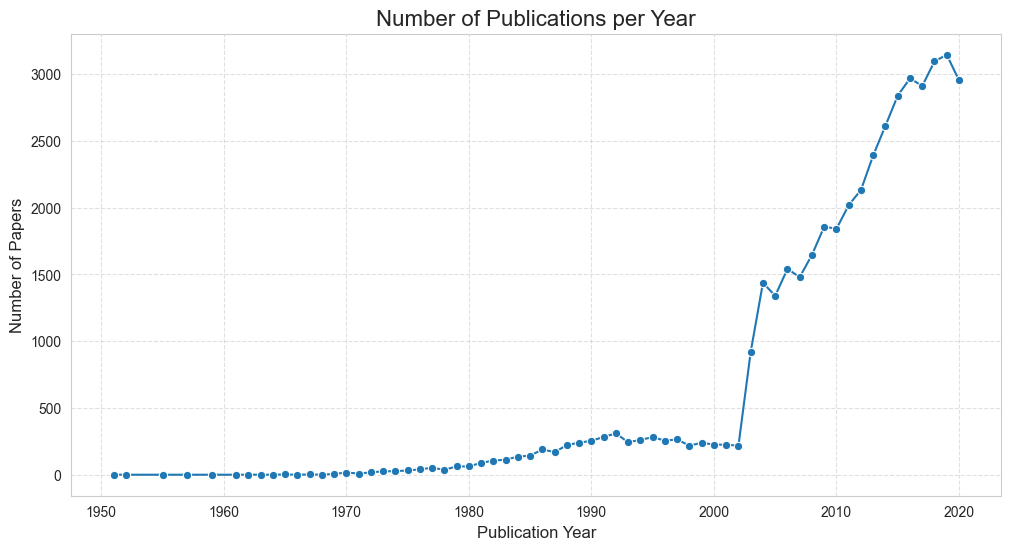

Top Journals:
 journal
Unknown                4065
Journal of Virology    1740
PLoS One               1567
Virology                865
Emerg Infect Dis        749
The Lancet              597
Viruses                 569
Arch Virol              504
Virus Research          495
Sci Rep                 491
Name: count, dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_18720\1338771082.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_journals.values, y=top_journals.index, palette="viridis")


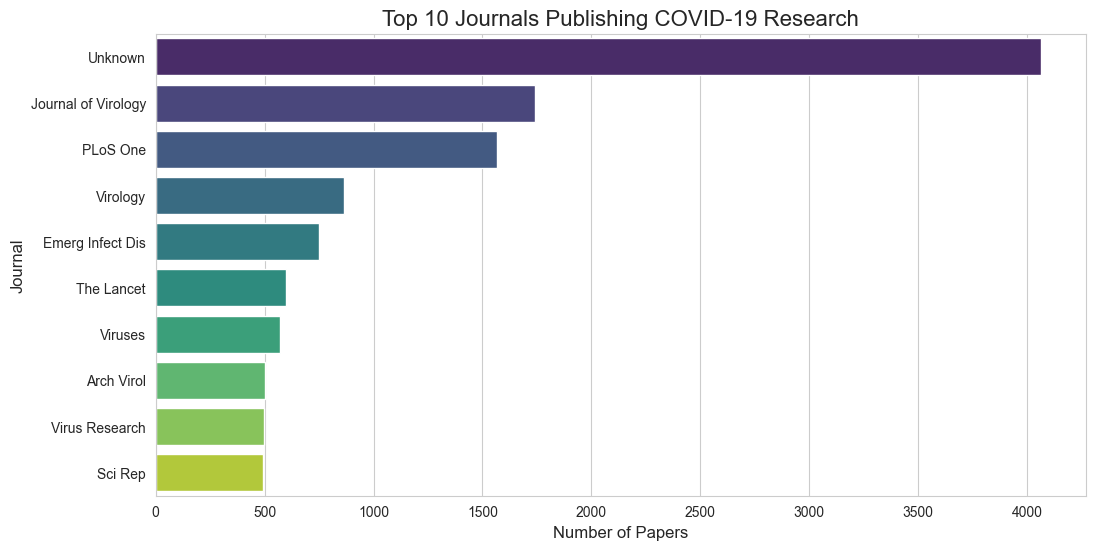

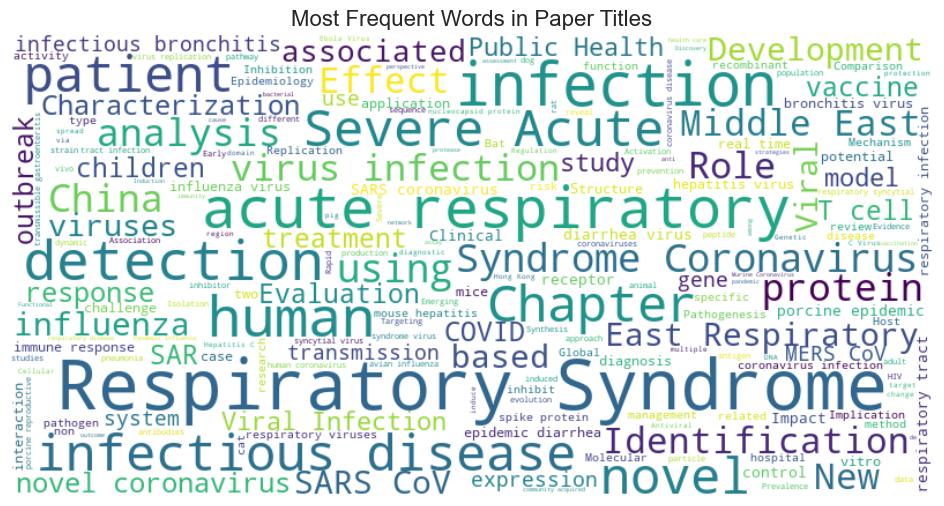

C:\Users\USER\AppData\Local\Temp\ipykernel_18720\1338771082.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=source_counts.values, y=source_counts.index, palette="cubehelix")


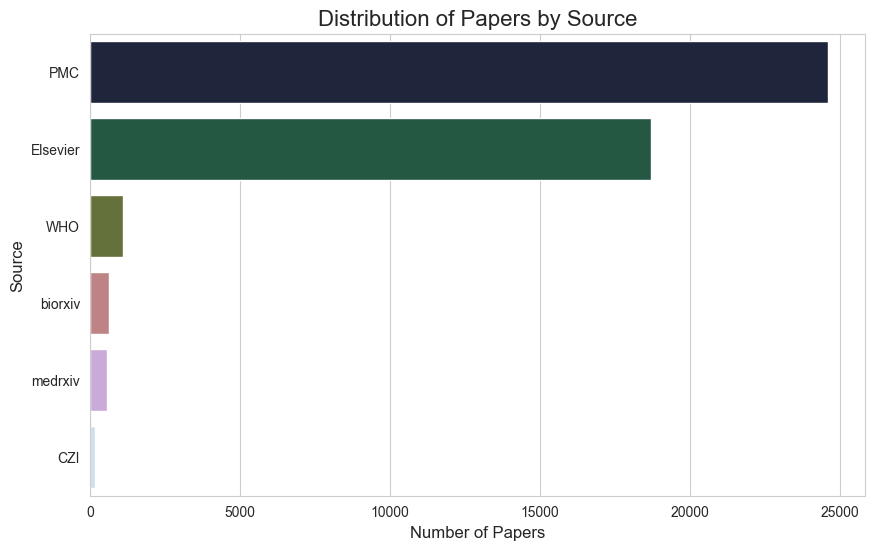

In [32]:
# ===============================
# Part 3: Data Analysis & Visualization
# ===============================

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Set style for plots
sns.set_style("whitegrid")

# -------------------------------
# Step 1: Publications over time
# -------------------------------

# Count papers by year
papers_per_year = df['publish_year'].value_counts().sort_index()

# Plot publications per year
plt.figure(figsize=(12,6))
sns.lineplot(x=papers_per_year.index, y=papers_per_year.values, marker="o")

plt.title("Number of Publications per Year", fontsize=16)
plt.xlabel("Publication Year", fontsize=12)
plt.ylabel("Number of Papers", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# -------------------------------
# Step 2: Top Journals
# -------------------------------

# Count papers per journal (ignoring 'Unknown')
top_journals = df['journal'].value_counts().head(10)
print("Top Journals:\n", top_journals)

# Plot top journals
plt.figure(figsize=(12,6))
sns.barplot(x=top_journals.values, y=top_journals.index, palette="viridis")

plt.title("Top 10 Journals Publishing COVID-19 Research", fontsize=16)
plt.xlabel("Number of Papers", fontsize=12)
plt.ylabel("Journal", fontsize=12)
plt.show()

# -------------------------------
# Step 3: Word Cloud of Titles
# -------------------------------

# Combine all titles into one string
title_text = " ".join(df['title'].astype(str))

# Define stopwords (common words to ignore)
stopwords = set(STOPWORDS)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white",
                      stopwords=stopwords, colormap="viridis").generate(title_text)

# Plot word cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Paper Titles", fontsize=16)
plt.show()

# -------------------------------
# Step 4: Distribution by Source
# -------------------------------

# Count papers by source
source_counts = df['source_x'].value_counts()

# Plot distribution by source
plt.figure(figsize=(10,6))
sns.barplot(x=source_counts.values, y=source_counts.index, palette="cubehelix")

plt.title("Distribution of Papers by Source", fontsize=16)
plt.xlabel("Number of Papers", fontsize=12)
plt.ylabel("Source", fontsize=12)
plt.show()


In [ ]:
# ===============================
# Part 4: Streamlit Application 
# ===============================

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Load cleaned dataset
df = pd.read_csv("metadata_cleaned.csv")

# Make sure publish_year exists
if 'publish_year' not in df.columns:
    df['publish_year'] = pd.to_datetime(df['publish_time'], errors='coerce').dt.year

# -------------------------------
# App Title & Description
# -------------------------------
st.title("COVID-19 Research Papers Explorer")
st.write("Explore COVID-19 research papers interactively with simple visualizations.")

# -------------------------------
# Show sample data
# -------------------------------
st.subheader("Sample of the Dataset")
st.dataframe(df.sample(5))  # Show 5 random rows

# -------------------------------
# Interactive Widget: Year Slider
# -------------------------------
year_min = int(df['publish_year'].min())
year_max = int(df['publish_year'].max())
selected_year = st.slider("Select Year", year_min, year_max, year_max)

# Filter data for selected year
df_year = df[df['publish_year'] == selected_year]
st.write(f"Number of papers in {selected_year}: {len(df_year)}")

# -------------------------------
# Visualization 1: Publications Over Time
# -------------------------------
st.subheader("Publications Over Time")
papers_per_year = df['publish_year'].value_counts().sort_index()
fig, ax = plt.subplots()
sns.lineplot(x=papers_per_year.index, y=papers_per_year.values, marker="o", ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Papers")
st.pyplot(fig)

# -------------------------------
# Visualization 2: Top 10 Journals
# -------------------------------
st.subheader("Top 10 Journals")
top_journals = df['journal'].value_counts().head(10)
fig, ax = plt.subplots()
sns.barplot(x=top_journals.values, y=top_journals.index, palette="viridis", ax=ax)
ax.set_xlabel("Number of Papers")
ax.set_ylabel("Journal")
st.pyplot(fig)

# -------------------------------
# Visualization 3: Word Cloud of Titles
# -------------------------------
st.subheader("Word Cloud of Paper Titles")
title_text = " ".join(df['title'].astype(str))
wordcloud = WordCloud(width=800, height=400, stopwords=set(STOPWORDS),
                      background_color="white").generate(title_text)
fig, ax = plt.subplots()
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
st.pyplot(fig)

# -------------------------------
# Visualization 4: Papers by Source
# -------------------------------
st.subheader("Distribution by Source")
source_counts = df['source_x'].value_counts()
fig, ax = plt.subplots()
sns.barplot(x=source_counts.values, y=source_counts.index, palette="cubehelix", ax=ax)
ax.set_xlabel("Number of Papers")
ax.set_ylabel("Source")
st.pyplot(fig)
